<a href="https://www.kaggle.com/code/lakshmipriya190803/reddit-comments-analysis-using-nlp-and-dl?scriptVersionId=163881913" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Welcome :)

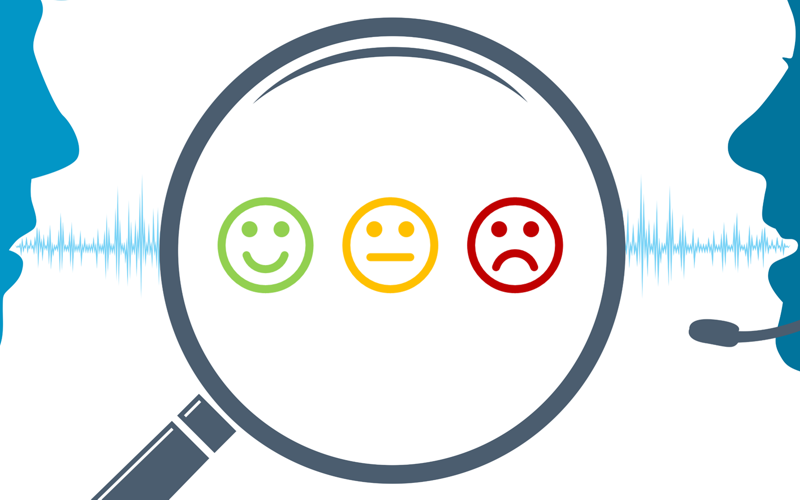

Let's explore Reddit Comments Sentiment Analysis using Machine Learning and Deep Learning. 

# Exploratory Data Analysis

Exploratory Data Analysis (EDA) is essential for effective sentiment analysis. It helps understand sentiment label distribution, identify text preprocessing needs, and select relevant features. EDA also addresses imbalanced classes, detects outliers, and visualizes data trends. This process enhances model interpretability and ensures robust sentiment analysis by informing decisions on preprocessing steps, feature selection, and model design.

In [1]:
!pip install vaderSentiment
!pip install twython
!pip install keras
!pip install np_utils
!pip install nltk
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 731.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56439 sha256=bd17bff209551ed2803e52d027c230b36aa0240144acf5b54160eae588677553
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.2

In [2]:
!pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1


In [3]:
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.3 MB/s eta 0:00:00


In [4]:
import pandas as pd 
import numpy as np
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 

from nltk.tokenize import RegexpTokenizer
import re
import string


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer


from keras.preprocessing import sequence, text
from tqdm import tqdm
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential


from keras.layers import LSTM, GRU,SimpleRNN
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
#from keras.utils.module_utils import tensorflow as tf
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping


In [5]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)


Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


2024-02-22 17:05:46.956083: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-22 17:05:46.956197: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-22 17:05:46.956294: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-22 17:05:46.956421: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-22 17:05:46.956540: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-22 17:05:46.956773: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-22 17:05:46.956871: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


REPLICAS:  8


In [6]:
df_1 = pd.read_csv("/kaggle/input/chatgpt-reddit/chatgpt-reddit-comments.csv")
df_1.head(5)

,Unnamed: 0,comment_id,comment_parent_id,comment_body,subreddit
0,0,iztdxuh,t3_zj2aeu,"I've been shocked for days now, I don't need c...",r/ChatGPT
1,1,iztn0q0,t3_zj2aeu,\n\nI am so angry right now. I just wasted my...,r/ChatGPT
2,2,izudrph,t3_zj2aeu,chatgpt karma whoring is here folks! just when...,r/ChatGPT
3,3,iztfhtb,t3_zj2aeu,"Worked on me, ngl.",r/ChatGPT
4,4,izu2as9,t3_zj2aeu,"Certified 10/10, must-see moment. It really di...",r/ChatGPT


In [7]:
df_1.describe()

,Unnamed: 0,comment_id,comment_parent_id,comment_body,subreddit
count,52413,52415,52415,52415,52415
unique,29712,52413,22596,51042,5
top,671,comment_id,t3_107vs7i,[deleted],r/ChatGPT
freq,4,3,239,661,29711


In [8]:
print(f"Null values ? \n{df_1.isnull().sum()}")

Null values ? 
Unnamed: 0           3
comment_id           1
comment_parent_id    1
comment_body         1
subreddit            1
dtype: int64


In [9]:
print("since we've got some null values, let's remove that first")
df_1.dropna(inplace = True)
df_1.isna().sum()
print(f"Null values ? \n{df_1.isnull().sum()}")

since we've got some null values, let's remove that first
Null values ? 
Unnamed: 0           0
comment_id           0
comment_parent_id    0
comment_body         0
subreddit            0
dtype: int64


so far we can see the first column just contains the index, we've got id of the person commenting, what they've commented and the subreddit, NO *labels*

there are so many patterns we could look for
is there any relation between the average sentiment of comments and subreddits?
how is the overall sentiment of comments

My overall focus is going to be on comments themselves so commenter's id will be irrelevant
Although one thing I might go on look further a person would be whether they were siding with the group and how many were like them or whether their opinions stayed constant throughout subreddits 
this will be something i would look at, at the very last obviously!


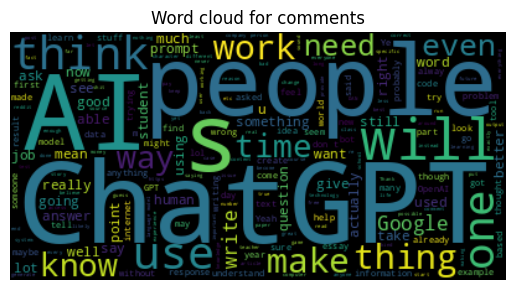

In [10]:
comments = df_1['comment_body']
text = ' '.join(comments.astype(str).tolist())

wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word cloud for comments")
plt.show()

## Data Preparation

Okay from now on I will be focusing entirely on the 'Comment body' 
We do not have labels so there's two things we could do:

1. Go unsupervised
2. Use sentiment analysers to give a rating to each comment based on lexicon

Let's try both and see where we go
Either way the data needs to be cleaned before we proceed further

## Applying Vader Sentiment Analysis to obtain Labels

VADER SENTIMENT ANALYSIS SCORES are affected by factors like punctuations,capitalization,preceeding-trigrams,degree modifiers,conjunctions etc.

So without Data Preparation, we will apply VADER 

In [11]:
len(df_1['comment_body'])

52412

In [12]:
def clean(text):
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('<.*?>+', '', text)
    return text
    


df_1['comment_body'] = df_1['comment_body'].apply(lambda x:clean(x))
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
scores=[]
for index, row in df_1.dropna().iterrows():
    score = analyser.polarity_scores(row['comment_body'])
    score=score['compound']
    scores.append(score)
    
sentiment=[]
for i in scores:
    if i>=0.05:
        sentiment.append('Positive')
    elif i<=(-0.05):
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')
        
df_1['sentiment']=pd.Series(np.array(sentiment))

In [13]:
df_1.head()

,Unnamed: 0,comment_id,comment_parent_id,comment_body,subreddit,sentiment
0,0,iztdxuh,t3_zj2aeu,"I've been shocked for days now, I don't need c...",r/ChatGPT,Negative
1,1,iztn0q0,t3_zj2aeu,I am so angry right now. I just wasted my tim...,r/ChatGPT,Negative
2,2,izudrph,t3_zj2aeu,chatgpt karma whoring is here folks! just when...,r/ChatGPT,Negative
3,3,iztfhtb,t3_zj2aeu,"Worked on me, ngl.",r/ChatGPT,Neutral
4,4,izu2as9,t3_zj2aeu,"Certified /, must-see moment. It really did sh...",r/ChatGPT,Negative


## Data Prep using Stemming and Lemmatizing 

In [14]:
df = df_1
df.drop(['Unnamed: 0', 'comment_id', 'comment_parent_id'], inplace = True, axis = 1)
df.head()

,comment_body,subreddit,sentiment
0,"I've been shocked for days now, I don't need c...",r/ChatGPT,Negative
1,I am so angry right now. I just wasted my tim...,r/ChatGPT,Negative
2,chatgpt karma whoring is here folks! just when...,r/ChatGPT,Negative
3,"Worked on me, ngl.",r/ChatGPT,Neutral
4,"Certified /, must-see moment. It really did sh...",r/ChatGPT,Negative


In [15]:
#converting all text to lowercase
df['comment_body'] = df['comment_body'].str.lower()
df.head(5)

,comment_body,subreddit,sentiment
0,"i've been shocked for days now, i don't need c...",r/ChatGPT,Negative
1,i am so angry right now. i just wasted my tim...,r/ChatGPT,Negative
2,chatgpt karma whoring is here folks! just when...,r/ChatGPT,Negative
3,"worked on me, ngl.",r/ChatGPT,Neutral
4,"certified /, must-see moment. it really did sh...",r/ChatGPT,Negative


In [16]:
#cleaning and removing stopwords
'''
stopwords_list = set(stopwords.words('english'))
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stopwords_list])

df['comment_body'] = df['comment_body'].apply(lambda text : cleaning_stopwords(text))
df.head()
'''

'\nstopwords_list = set(stopwords.words(\'english\'))\ndef cleaning_stopwords(text):\n    return " ".join([word for word in str(text).split() if word not in stopwords_list])\n\ndf[\'comment_body\'] = df[\'comment_body\'].apply(lambda text : cleaning_stopwords(text))\ndf.head()\n'

In [17]:
#cleaning and removing punctuations 
english_punctuations = string.punctuation

def cleaning_punctuations(text):
    translator = str.maketrans('','', english_punctuations)
    return text.translate(translator)

df['comment_body'] = df['comment_body'].apply(lambda x: cleaning_punctuations(x))
df.head(5)

,comment_body,subreddit,sentiment
0,ive been shocked for days now i dont need clic...,r/ChatGPT,Negative
1,i am so angry right now i just wasted my time...,r/ChatGPT,Negative
2,chatgpt karma whoring is here folks just when ...,r/ChatGPT,Negative
3,worked on me ngl,r/ChatGPT,Neutral
4,certified mustsee moment it really did shock ...,r/ChatGPT,Negative


In [18]:
#cleaning and removing repeating characters:

def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

df['comment_body'] = df['comment_body'].apply(lambda x: cleaning_repeating_char(x))
df.head()

,comment_body,subreddit,sentiment
0,ive ben shocked for days now i dont ned clickbait,r/ChatGPT,Negative
1,i am so angry right now i just wasted my time...,r/ChatGPT,Negative
2,chatgpt karma whoring is here folks just when ...,r/ChatGPT,Negative
3,worked on me ngl,r/ChatGPT,Neutral
4,certified mustse moment it realy did shock me ...,r/ChatGPT,Negative


In [19]:
#cleaning and removing url's

def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ', data)

df['comment_body'] = df['comment_body'].apply(lambda x: cleaning_URLs(x))
df.head()

,comment_body,subreddit,sentiment
0,ive ben shocked for days now i dont ned clickbait,r/ChatGPT,Negative
1,i am so angry right now i just wasted my time...,r/ChatGPT,Negative
2,chatgpt karma whoring is here folks just when ...,r/ChatGPT,Negative
3,worked on me ngl,r/ChatGPT,Neutral
4,certified mustse moment it realy did shock me ...,r/ChatGPT,Negative


In [20]:
#cleaning and removing numbers
def cleaning_numbers(data):
    return re.sub('[0-9]+','',data)

df['comment_body'] = df['comment_body'].apply(lambda x: cleaning_numbers(x))
df.head()

,comment_body,subreddit,sentiment
0,ive ben shocked for days now i dont ned clickbait,r/ChatGPT,Negative
1,i am so angry right now i just wasted my time...,r/ChatGPT,Negative
2,chatgpt karma whoring is here folks just when ...,r/ChatGPT,Negative
3,worked on me ngl,r/ChatGPT,Neutral
4,certified mustse moment it realy did shock me ...,r/ChatGPT,Negative


In [21]:
# tokenizing the comments

tokeniser = RegexpTokenizer(r'\w+')
df['comment_body'] = df['comment_body'].apply(tokeniser.tokenize)
df.head()

,comment_body,subreddit,sentiment
0,"[ive, ben, shocked, for, days, now, i, dont, n...",r/ChatGPT,Negative
1,"[i, am, so, angry, right, now, i, just, wasted...",r/ChatGPT,Negative
2,"[chatgpt, karma, whoring, is, here, folks, jus...",r/ChatGPT,Negative
3,"[worked, on, me, ngl]",r/ChatGPT,Neutral
4,"[certified, mustse, moment, it, realy, did, sh...",r/ChatGPT,Negative


In [22]:
#Applying stemming

st = nltk.PorterStemmer()

def stemming_on_text(data):
    data = [st.stem(word) for word in data]
    return data

df['comment_body'] = df['comment_body'].apply(lambda x: stemming_on_text(x))

df.head()

,comment_body,subreddit,sentiment
0,"[ive, ben, shock, for, day, now, i, dont, ned,...",r/ChatGPT,Negative
1,"[i, am, so, angri, right, now, i, just, wast, ...",r/ChatGPT,Negative
2,"[chatgpt, karma, whore, is, here, folk, just, ...",r/ChatGPT,Negative
3,"[work, on, me, ngl]",r/ChatGPT,Neutral
4,"[certifi, musts, moment, it, reali, did, shock...",r/ChatGPT,Negative


In [23]:
import nltk
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [24]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.


In [25]:
#lemmatizer 
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    data = [lm.lemmatize(word) for word in data]
    return data

df['comment_body'] = df['comment_body'].apply(lambda x: lemmatizer_on_text(x))
df.head()

,comment_body,subreddit,sentiment
0,"[ive, ben, shock, for, day, now, i, dont, ned,...",r/ChatGPT,Negative
1,"[i, am, so, angri, right, now, i, just, wast, ...",r/ChatGPT,Negative
2,"[chatgpt, karma, whore, is, here, folk, just, ...",r/ChatGPT,Negative
3,"[work, on, me, ngl]",r/ChatGPT,Neutral
4,"[certifi, must, moment, it, reali, did, shock,...",r/ChatGPT,Negative


In [26]:
df.head()

,comment_body,subreddit,sentiment
0,"[ive, ben, shock, for, day, now, i, dont, ned,...",r/ChatGPT,Negative
1,"[i, am, so, angri, right, now, i, just, wast, ...",r/ChatGPT,Negative
2,"[chatgpt, karma, whore, is, here, folk, just, ...",r/ChatGPT,Negative
3,"[work, on, me, ngl]",r/ChatGPT,Neutral
4,"[certifi, must, moment, it, reali, did, shock,...",r/ChatGPT,Negative


In [27]:
var1 = df.groupby('sentiment').count()['comment_body'].reset_index().sort_values(by='comment_body',ascending=False)
sns.set_style("white")
sns.set_palette("Set2")
var1.style.background_gradient()

,sentiment,comment_body
2,Positive,26335
1,Neutral,13363
0,Negative,12711


<Axes: xlabel='sentiment', ylabel='count'>

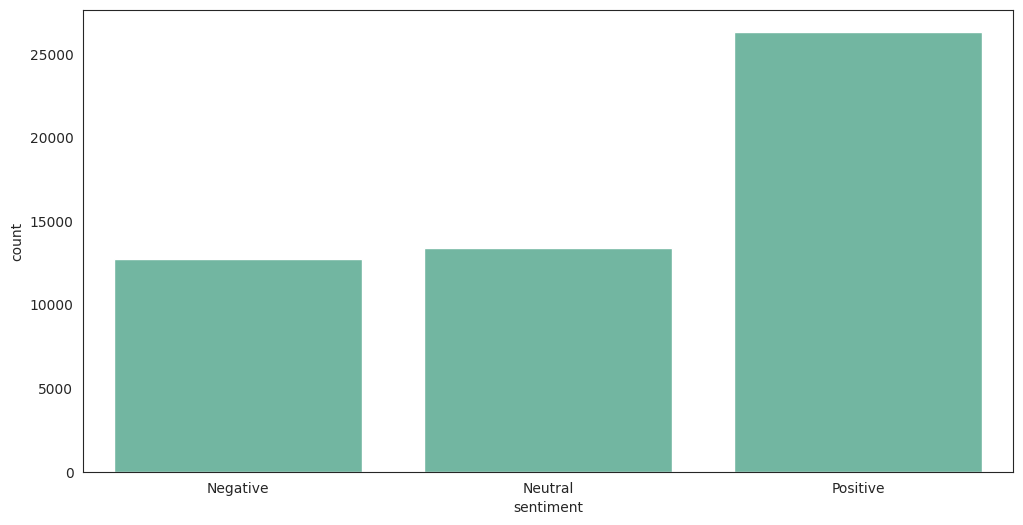

In [28]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=df)

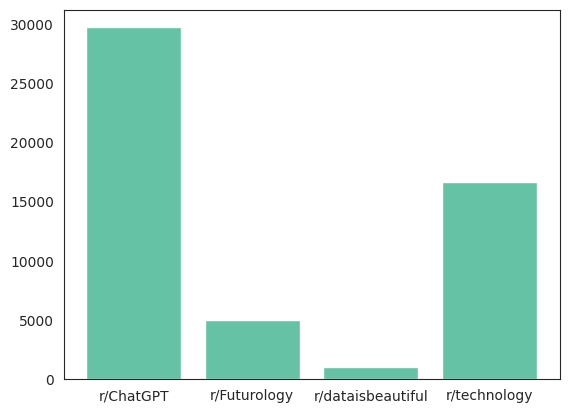

In [29]:
classes, class_counts = np.unique(df['subreddit'].to_numpy(), return_counts = True)
plt.bar(classes, class_counts)
plt.show()

<Figure size 1000x600 with 0 Axes>

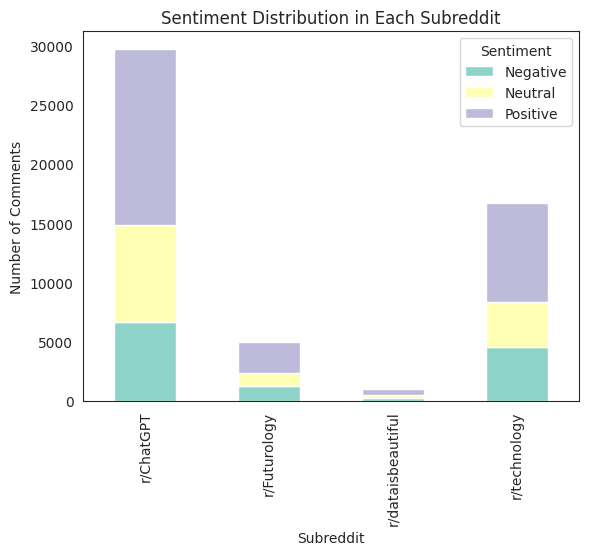

In [30]:
sentiment_counts = df.groupby(['subreddit', 'sentiment']).size().unstack(fill_value=0)
plt.figure(figsize=(10,6))
sns.set_palette("Set3")
sentiment_counts.plot(kind='bar', stacked=True)
plt.title('Sentiment Distribution in Each Subreddit')
plt.xlabel('Subreddit')
plt.ylabel('Number of Comments')
plt.legend(title='Sentiment', bbox_to_anchor=(1,1))
plt.show()

## Classifiers!!!
Here We come!!!

In [31]:
df.isnull().sum()
df.dropna()

,comment_body,subreddit,sentiment
0,"[ive, ben, shock, for, day, now, i, dont, ned,...",r/ChatGPT,Negative
1,"[i, am, so, angri, right, now, i, just, wast, ...",r/ChatGPT,Negative
2,"[chatgpt, karma, whore, is, here, folk, just, ...",r/ChatGPT,Negative
3,"[work, on, me, ngl]",r/ChatGPT,Neutral
4,"[certifi, must, moment, it, reali, did, shock,...",r/ChatGPT,Negative
...,...,...,...
52407,"[problem, is, those, ai, are, gete, le, and, l...",r/technology,Positive
52408,"[that, not, what, i, said, at, al, in, fact, i...",r/technology,Positive
52409,"[re, wikipedia, although, student, have, gete,...",r/technology,Negative
52410,"[scari, thing, is, in, thi, futur, text, won, ...",r/technology,Neutral


In [32]:
df = df.dropna(subset=['sentiment'])
df.isnull().sum()

comment_body    0
subreddit       0
sentiment       0
dtype: int64

In [33]:
X = df['comment_body']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=42)

In [34]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((41927,), (10482,), (41927,), (10482,))

In [35]:
def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

# Simple RNN

In [36]:
# using keras tokenizer
from keras.preprocessing import sequence, text
token = text.Tokenizer(num_words = None)
max_len = 1500

token.fit_on_texts(list(X_train))
x_train_seq = token.texts_to_sequences(X_train)
x_test_seq = token.texts_to_sequences(X_test)

#zero pad the sequences, 
x_train_pad = sequence.pad_sequences(x_train_seq, maxlen = max_len)
x_test_pad = sequence.pad_sequences(x_test_seq, maxlen = max_len)

word_index = token.word_index


In [37]:
y_train, y_test

(11028     Neutral
 27330    Negative
 9666      Neutral
 1977     Positive
 31279     Neutral
            ...   
 11284    Negative
 44735    Positive
 38161    Negative
 860      Negative
 15795    Positive
 Name: sentiment, Length: 41927, dtype: object,
 45061    Positive
 42344    Positive
 4264      Neutral
 12883    Negative
 46730    Positive
            ...   
 43418    Positive
 12104    Negative
 47947     Neutral
 18621    Positive
 36070    Negative
 Name: sentiment, Length: 10482, dtype: object)

In [38]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(["Positive", "Negative", "Neutral"])
y_train = encoder.transform(y_train)

y_test = encoder.transform(y_test)
y_test, y_train

classes = np.unique(y_train)

In [39]:
#from tensorflow.keras.utils import to_categorical
#y_train = to_categorical(y_train, classes)
#y_train

In [40]:

%%time
with strategy.scope():
    # A simpleRNN without any pretrained embeddings and one dense layer
    model_1 = Sequential()
    model_1.add(Embedding(len(word_index) + 1,
                     300,
                     input_length=max_len))
    model_1.add(SimpleRNN(100))
    model_1.add(Dense(len(classes), activation='softmax'))
    model_1.compile(loss= 'sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
model_1.summary()


2024-02-22 17:07:11.812071: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-22 17:07:11.812198: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1500, 300)         7374300   
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               40100     
                                                                 
 dense (Dense)               (None, 3)                 303       
                                                                 
Total params: 7414703 (28.28 MB)
Trainable params: 7414703 (28.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
CPU times: user 2.01 s, sys: 441 ms, total: 2.45 s
Wall time: 2.04 s


In [41]:
x_train_pad.shape, y_train.shape

((41927, 1500), (41927,))

In [42]:
model_1.fit(x_train_pad, y_train, epochs=5, batch_size=64*strategy.num_replicas_in_sync)

Epoch 1/5


2024-02-22 17:07:14.557977: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-22 17:07:14.576067: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-22 17:07:14.594534: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-22 17:07:14.613092: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-22 17:07:14.631266: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-22 17:07:14.649094: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-22 17:07:14.667960: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

 2/82 [..............................] - ETA: 5s - loss: 1.1155 - accuracy: 0.3213   

2024-02-22 17:07:22.638417: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-22 17:07:22.638554: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-22 17:07:22.638644: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-22 17:07:22.638738: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-22 17:07:22.638840: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-22 17:07:22.638987: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-22 17:07:22.639120: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

 7/82 [=>............................] - ETA: 4s - loss: 1.0511 - accuracy: 0.4590

2024-02-22 17:07:22.910478: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


81/82 [============================>.] - ETA: 0s - loss: 0.9853 - accuracy: 0.5337

2024-02-22 17:07:27.690110: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-22 17:07:27.690402: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


82/82 [==============================] - 19s 130ms/step - loss: 0.9850 - accuracy: 0.5340
Epoch 2/5
82/82 [==============================] - 5s 61ms/step - loss: 0.7971 - accuracy: 0.6615
Epoch 3/5


2024-02-22 17:07:38.183729: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-22 17:07:38.183864: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


82/82 [==============================] - 5s 62ms/step - loss: 0.9427 - accuracy: 0.5961
Epoch 4/5
80/82 [============================>.] - ETA: 0s - loss: 0.9367 - accuracy: 0.5774

2024-02-22 17:07:48.205871: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


82/82 [==============================] - 5s 61ms/step - loss: 0.9368 - accuracy: 0.5766
Epoch 5/5
82/82 [==============================] - 5s 62ms/step - loss: 0.9053 - accuracy: 0.5922


In [43]:
y_pred_probs = model_1.predict(x_test_pad)
y_pred = y_pred_probs.argmax(axis=1)
y_pred

328/328 [==============================] - 7s 18ms/step


array([2, 2, 2, ..., 2, 2, 0])

In [44]:
np.unique(y_pred)

array([0, 1, 2])

In [45]:
target_names = ["Positive", "Negative", "Neutral"]

In [46]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Positive       0.42      0.07      0.12      2544
    Negative       0.40      0.09      0.15      2690
     Neutral       0.51      0.92      0.66      5248

    accuracy                           0.50     10482
   macro avg       0.44      0.36      0.31     10482
weighted avg       0.46      0.50      0.40     10482



# LSTM's

In [47]:
# load the GloVe vectors in a dictionary:
embeddings_index = {}
f = open('/kaggle/input/glove840b300dtxt/glove.840B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


2196018it [03:08, 11660.85it/s]

Found 2196017 word vectors.


In [48]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 24580/24580 [00:00<00:00, 319338.85it/s]


In [49]:
%%time
with strategy.scope():
    
    # A simple LSTM with glove embeddings and one dense layer
    model_2 = Sequential()
    model_2.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

    model_2.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
    model_2.add(Dense(len(classes), activation='softmax'))
    model_2.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1500, 300)         7374300   
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense_1 (Dense)             (None, 3)                 303       
                                                                 
Total params: 7535003 (28.74 MB)
Trainable params: 160703 (627.75 KB)
Non-trainable params: 7374300 (28.13 MB)
_________________________________________________________________
CPU times: user 2.01 s, sys: 273 ms, total: 2.28 s
Wall time: 1.76 s


In [50]:
model_2.fit(x_train_pad, y_train, epochs=5, batch_size=64*strategy.num_replicas_in_sync)

Epoch 1/5


2024-02-22 17:11:17.403009: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.
2024-02-22 17:11:17.801526: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


78/82 [===========================>..] - ETA: 0s - loss: 0.9907 - accuracy: 0.5331

2024-02-22 17:11:33.013086: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


82/82 [==============================] - 23s 191ms/step - loss: 0.9894 - accuracy: 0.5333
Epoch 2/5
82/82 [==============================] - 12s 150ms/step - loss: 0.9408 - accuracy: 0.5642
Epoch 3/5
82/82 [==============================] - 12s 150ms/step - loss: 0.9198 - accuracy: 0.5789
Epoch 4/5
82/82 [==============================] - 12s 150ms/step - loss: 0.9069 - accuracy: 0.5869
Epoch 5/5
82/82 [==============================] - 12s 150ms/step - loss: 0.8928 - accuracy: 0.5987


In [51]:
y_pred_1 = model_2.predict(x_test_pad)

2024-02-22 17:12:28.067315: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


328/328 [==============================] - 16s 43ms/step


In [52]:
y_pred_1 = y_pred_1.argmax(axis=1)
y_pred_1

array([2, 2, 1, ..., 2, 2, 0])

In [53]:
print(classification_report(y_test, y_pred_1, target_names=target_names))

              precision    recall  f1-score   support

    Positive       0.51      0.20      0.29      2544
    Negative       0.60      0.44      0.51      2690
     Neutral       0.59      0.84      0.69      5248

    accuracy                           0.59     10482
   macro avg       0.57      0.50      0.50     10482
weighted avg       0.57      0.59      0.55     10482



# Gated Recurrent Unit

In [54]:
%%time
with strategy.scope():
    # GRU with glove embeddings and two dense layers
     model_3 = Sequential()
     model_3.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
     model_3.add(SpatialDropout1D(0.3))
     model_3.add(GRU(300))
     model_3.add(Dense(3, activation='softmax'))

     model_3.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])   
    
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1500, 300)         7374300   
                                                                 
 spatial_dropout1d (Spatial  (None, 1500, 300)         0         
 Dropout1D)                                                      
                                                                 
 gru (GRU)                   (None, 300)               541800    
                                                                 
 dense_2 (Dense)             (None, 3)                 903       
                                                                 
Total params: 7917003 (30.20 MB)
Trainable params: 542703 (2.07 MB)
Non-trainable params: 7374300 (28.13 MB)
_________________________________________________________________
CPU times: user 6.15 s, sys: 456 ms, total: 6.6 s
Wall time: 2.42 s


In [55]:
model_3.fit(x_train_pad, y_train, epochs=5, batch_size=64*strategy.num_replicas_in_sync)

Epoch 1/5
82/82 [==============================] - 23s 193ms/step - loss: 0.9977 - accuracy: 0.5324
Epoch 2/5
82/82 [==============================] - 13s 155ms/step - loss: 0.9383 - accuracy: 0.5682
Epoch 3/5
82/82 [==============================] - 13s 155ms/step - loss: 0.9114 - accuracy: 0.5862
Epoch 4/5
82/82 [==============================] - 13s 155ms/step - loss: 0.8982 - accuracy: 0.5949
Epoch 5/5
82/82 [==============================] - 13s 155ms/step - loss: 0.8853 - accuracy: 0.6031


In [56]:
y_pred_2 = model_3.predict(x_test_pad)
y_pred_2 = y_pred_2.argmax(axis=1)
y_pred_2

2024-02-22 17:14:04.049645: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


328/328 [==============================] - 14s 39ms/step


array([2, 2, 1, ..., 2, 2, 0])

In [57]:
print(classification_report(y_test, y_pred_2, target_names=target_names))

              precision    recall  f1-score   support

    Positive       0.51      0.24      0.32      2544
    Negative       0.59      0.49      0.53      2690
     Neutral       0.61      0.81      0.69      5248

    accuracy                           0.59     10482
   macro avg       0.57      0.51      0.52     10482
weighted avg       0.58      0.59      0.56     10482



# Bi-Directional RNN's

In [58]:
%%time
with strategy.scope():
    
    # A simple bidirectional LSTM with glove embeddings and one dense layer
    model_4 = Sequential()
    model_4.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

    model_4.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3)))
    model_4.add(Dense(len(classes), activation='softmax'))
    model_4.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1500, 300)         7374300   
                                                                 
 bidirectional (Bidirection  (None, 200)               320800    
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 3)                 603       
                                                                 
Total params: 7695703 (29.36 MB)
Trainable params: 321403 (1.23 MB)
Non-trainable params: 7374300 (28.13 MB)
_________________________________________________________________
CPU times: user 953 ms, sys: 198 ms, total: 1.15 s
Wall time: 1.04 s


In [59]:
model_4.fit(x_train_pad, y_train, epochs=5, batch_size=64*strategy.num_replicas_in_sync)

Epoch 1/5
82/82 [==============================] - 40s 348ms/step - loss: 0.9920 - accuracy: 0.5295
Epoch 2/5
82/82 [==============================] - 23s 286ms/step - loss: 0.9415 - accuracy: 0.5631
Epoch 3/5
82/82 [==============================] - 23s 286ms/step - loss: 0.9186 - accuracy: 0.5804
Epoch 4/5
82/82 [==============================] - 23s 286ms/step - loss: 0.9041 - accuracy: 0.5897
Epoch 5/5
82/82 [==============================] - 23s 286ms/step - loss: 0.8934 - accuracy: 0.5967


In [60]:
y_pred_3 = model_4.predict(x_test_pad)
y_pred_3 = y_pred_3.argmax(axis=1)
y_pred_3

2024-02-22 17:16:36.918276: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


328/328 [==============================] - 27s 76ms/step


array([2, 2, 1, ..., 2, 2, 0])

In [61]:
print(classification_report(y_test, y_pred_2, target_names=target_names))

              precision    recall  f1-score   support

    Positive       0.51      0.24      0.32      2544
    Negative       0.59      0.49      0.53      2690
     Neutral       0.61      0.81      0.69      5248

    accuracy                           0.59     10482
   macro avg       0.57      0.51      0.52     10482
weighted avg       0.58      0.59      0.56     10482



In [62]:
'''
from sklearn.naive_bayes import MultinomialNB
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Assuming X_train and X_test are your feature matrices, and y_train is the target variable

# Step 1: Separate text and numerical columns
text_cols = X_train.select_dtypes(include=['object']).columns
numerical_cols = X_train.select_dtypes(include=['number']).columns

# Step 2: Impute NaN values for text data with an empty string and numerical data with 0
imputer_text = SimpleImputer(strategy='constant', fill_value='')
X_train_imputed_text = pd.DataFrame(imputer_text.fit_transform(X_train[text_cols]), columns=text_cols)
X_test_imputed_text = pd.DataFrame(imputer_text.transform(X_test[text_cols]), columns=text_cols)

imputer_numeric = SimpleImputer(strategy='constant', fill_value=0)
X_train_imputed_numeric = pd.DataFrame(imputer_numeric.fit_transform(X_train[numerical_cols]), columns=numerical_cols)
X_test_imputed_numeric = pd.DataFrame(imputer_numeric.transform(X_test[numerical_cols]), columns=numerical_cols)

# Step 3: Concatenate the imputed text and numerical data
X_train_imputed = pd.concat([X_train_imputed_text, X_train_imputed_numeric], axis=1)
X_test_imputed = pd.concat([X_test_imputed_text, X_test_imputed_numeric], axis=1)

# Step 4: Vectorize your text data
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 1))  # You can customize this based on your needs
X_train_vectorized = vectorizer.fit_transform(X_train_imputed[text_cols])
X_test_vectorized = vectorizer.transform(X_test_imputed[text_cols])

# Step 5: Train the Multinomial Naive Bayes model
MNB = MultinomialNB()
MNB.fit(X_train_vectorized, y_train)

# Step 6: Make predictions
predicted = MNB.predict(X_test_vectorized)
'''

"\nfrom sklearn.naive_bayes import MultinomialNB\nfrom sklearn.impute import SimpleImputer\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.feature_extraction.text import CountVectorizer\n\n# Assuming X_train and X_test are your feature matrices, and y_train is the target variable\n\n# Step 1: Separate text and numerical columns\ntext_cols = X_train.select_dtypes(include=['object']).columns\nnumerical_cols = X_train.select_dtypes(include=['number']).columns\n\n# Step 2: Impute NaN values for text data with an empty string and numerical data with 0\nimputer_text = SimpleImputer(strategy='constant', fill_value='')\nX_train_imputed_text = pd.DataFrame(imputer_text.fit_transform(X_train[text_cols]), columns=text_cols)\nX_test_imputed_text = pd.DataFrame(imputer_text.transform(X_test[text_cols]), columns=text_cols)\n\nimputer_numeric = SimpleImputer(strategy='constant', fill_value=0)\nX_train_imputed_numeric = pd.DataFrame(imputer_numeric.fit_transform(X_train[numerical_c

In [63]:
#df['comment_body']

In [64]:
'''
corpus = [' '.join(comment) for comment in df['comment_body']]

# Create a tokenizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')

# Create CountVectorizer
cv = CountVectorizer(stop_words='english', ngram_range=(1, 1), tokenizer=token.tokenize)

# Fit and transform the corpus
text_counts = cv.fit_transform(corpus)
'''

"\ncorpus = [' '.join(comment) for comment in df['comment_body']]\n\n# Create a tokenizer\ntoken = RegexpTokenizer(r'[a-zA-Z0-9]+')\n\n# Create CountVectorizer\ncv = CountVectorizer(stop_words='english', ngram_range=(1, 1), tokenizer=token.tokenize)\n\n# Fit and transform the corpus\ntext_counts = cv.fit_transform(corpus)\n"

In [65]:
'''
from sklearn.naive_bayes import MultinomialNB
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Assuming X_train and X_test are your feature matrices, and y_train is the target variable

# Step 1: Handle NaN values in X_train and X_test
imputer = SimpleImputer(strategy='constant', fill_value='')  # You can use different strategies depending on your data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Step 2: Vectorize your text data
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 1))  # You can customize this based on your needs
X_train_vectorized = vectorizer.fit_transform(X_train_imputed)
X_test_vectorized = vectorizer.transform(X_test_imputed)

# Step 3: Train the Multinomial Naive Bayes model
MNB = MultinomialNB()
MNB.fit(X_train_vectorized, y_train)

# Step 4: Make predictions
predicted = MNB.predict(X_test_vectorized)
'''

"\nfrom sklearn.naive_bayes import MultinomialNB\nfrom sklearn.impute import SimpleImputer\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.feature_extraction.text import CountVectorizer\n\n# Assuming X_train and X_test are your feature matrices, and y_train is the target variable\n\n# Step 1: Handle NaN values in X_train and X_test\nimputer = SimpleImputer(strategy='constant', fill_value='')  # You can use different strategies depending on your data\nX_train_imputed = imputer.fit_transform(X_train)\nX_test_imputed = imputer.transform(X_test)\n\n# Step 2: Vectorize your text data\nvectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 1))  # You can customize this based on your needs\nX_train_vectorized = vectorizer.fit_transform(X_train_imputed)\nX_test_vectorized = vectorizer.transform(X_test_imputed)\n\n# Step 3: Train the Multinomial Naive Bayes model\nMNB = MultinomialNB()\nMNB.fit(X_train_vectorized, y_train)\n\n# Step 4: Make predictions\npredicted

In [66]:

'''MNB = MultinomialNB()
MNB.fit(X_train, y_train)
predicted = MNB.predict(X_test)'''


'MNB = MultinomialNB()\nMNB.fit(X_train, y_train)\npredicted = MNB.predict(X_test)'

### Naive Bayes